In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score,f1_score,log_loss,\
classification_report, roc_curve

import warnings
warnings.filterwarnings("ignore");

RAND = 10

# Импорт данных

**Описания полей**

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Задача: предсказать флаг дефолта по кредиту

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,0
73795,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,0
73796,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,0
73797,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1


Датасет не очень большой, но можно распространить те же методы на более масштабные данные

In [5]:
print(f'Train size = {df.shape}')

Train size = (73799, 19)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Замечаем, что в образовании у нас имеются пропуски, в следующей ячейке мы считаем это в процентах

In [7]:
df.education.isna().sum() / df.shape[0]*100

0.41599479667746175

Также посмотрим на уникальные наименования, чуть ниже посторался дополнительно расшифровать эти значения:

In [8]:
df.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD', nan], dtype=object)

- SCH - school, школьное образование??

- GRD - graduate, выпускник

- UGR - undergraduates, старшекурсники

- PGR - аспирант

- ACD - академик?

Можем заполнить отсутствующие поля education, модой (это значение, которое появляется чаще всего. Это может быть несколько значений)

In [9]:
ed_mode = df.education.mode()[0]
df.education = df.education.fillna(ed_mode)

Переведем признаки в категориальный вид, там где выставлены в качестве значений категории по условию

Здесь можно посмотреть на средние и минимальные, максимальные значения зарплаты (income), также на другие значения. Значение 

In [10]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


Ищем уникальные значения в нашем датасете, нас заинтересовали home_adress, work_adress - там числа от 1-3

In [11]:
df.nunique()

client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

In [12]:
df.home_address.unique()

array([1, 2, 3], dtype=int64)

Выше увидим, наш массив, понимаем, что это категориальное значение, мы должны перевести его в object

In [13]:
df[['home_address', 'work_address']] = df[['home_address', 'work_address']].astype(object)

Можем вывести наши данные, которые имеют тип object

In [14]:
df.describe(include=object)

,app_date,education,sex,car,car_type,home_address,work_address,foreign_passport
count,73799,73799,73799,73799,73799,73799,73799,73799
unique,120,5,2,2,2,3,3,2
top,18MAR2014,SCH,F,N,N,2,3,N
freq,1018,39167,41562,49832,59791,39956,44959,62733


# Exploratory data analysis

**Гипотезы:**

- Возраст "хороших" заемщиков больше, по сравнению с "плохими" (распределения возраста в зависимости от флага дефолта смещено в большую сторону при default=0)
- Уровень образования зависит от возраста, что влияет и на возврат кредита, также люди с высшим образованием чаще являются "хорошими" заемщиками
- При good_work = 0 увеличивается риск невозврата кредита (флаг дефолта)
- Доход "хороших" заемщиков больше, по сравнению с "плохими" (распределения дохода в зависимости от флага дефолта смещено в большую сторону при default=0)
- score_bki напрямую взаимосвязан с default, чем он меньше, тем выше вероятность клиента выплатить кредит банку

## Target

Для начала необходимо изучить целевую переменную

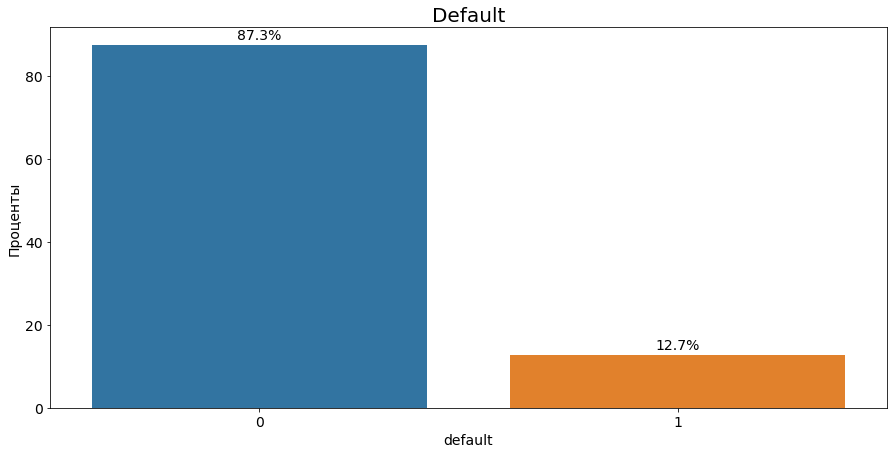

In [15]:
# нормирование на размер датасета
norm_target = (df
               .default
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Default', fontsize=20)

plt.xlabel('default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

В датесете присутствует дисбаланс классов, при обучении модели это стоит учитывать

## Age

Так как была гипотеза с возрастом, нормируются данные по возрасту и размеру классов

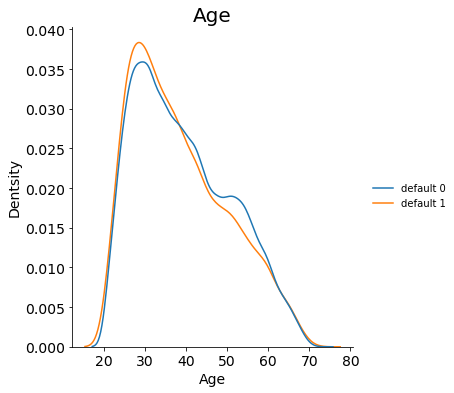

In [16]:
sns.displot(
    {
        "default 0": df[df.default == 0].age,
        "default 1": df[df.default == 1].age
    },
    kind="kde",
    common_norm=False # независимая нормализация каждого подмножества
)

plt.title('Age', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

На грфике зависимость не так сильно видна, возьмем медиану - разница в 2 года

In [17]:
df.groupby('default')['age'].median()

default
0    38.0
1    36.0
Name: age, dtype: float64

По среднему значению разница в 1 год

In [19]:
df.groupby('default')['age'].mean()

default
0    39.390504
1    38.525395
Name: age, dtype: float64

Если мы применим моду, то разница на 5 лет

In [21]:
df.groupby('default')['age'].apply(lambda x: x.value_counts().index[0]).reset_index()

,default,age
0,0,31
1,1,26


Есть небольшие различия по возрасту в разрезе default, гипотеза подтвердилась

## Education

Проверяем гипотезу на счет образования, ниже строим график, где показываем различные типы образования, относительно возраста

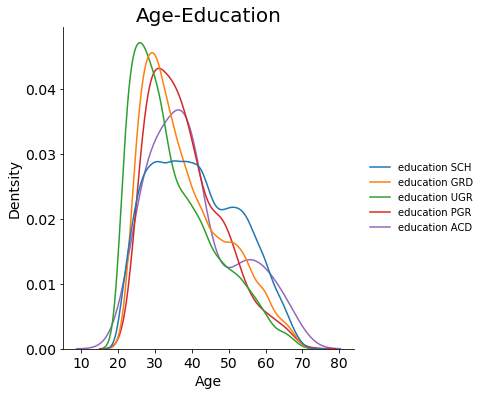

In [22]:
sns.displot(
    {
        "education SCH": df[df.education == 'SCH'].age,
        "education GRD": df[df.education == 'GRD'].age,
        "education UGR": df[df.education == 'UGR'].age,
        "education PGR": df[df.education == 'PGR'].age,
        "education ACD": df[df.education == 'ACD'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-Education', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Если берем образование SCH (возможно другая расшифровка), то возраст смещен в большую сторону, по сравнению с тем же UGR. 

Для ACD (академик) характерно смещено распределения возраста влево, если сравниваем с PGR (аспират), что и понятно в принципе. 

Самые молодые - UGR, есть преположение, что в большей степени они будут являться "плохими" заемщиками. 

Но намного нагляднее это будет увидеть на боксплотах, здесь можно увидеть, ту же зависимость, а также выбросы. Их большое количество в Аспирантах, потому что они могут быть и старыми

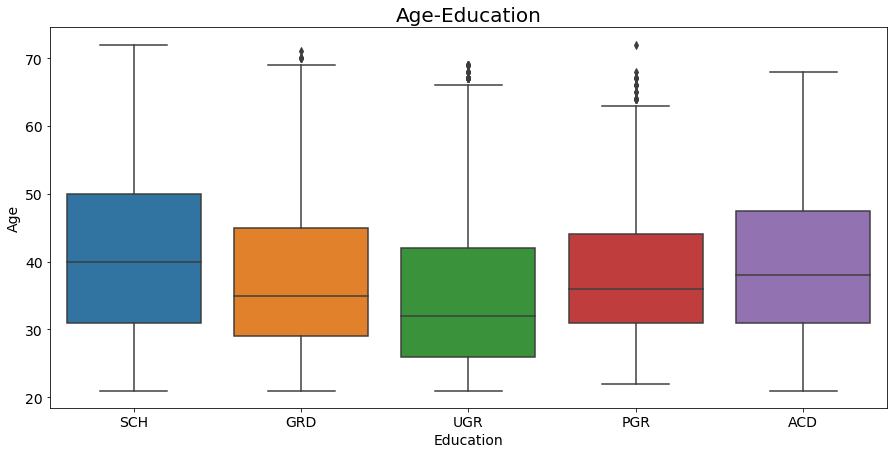

In [23]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', data=df)

plt.title('Age-Education', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Также если разграничить по классам, то заметен разброс у Академиков 

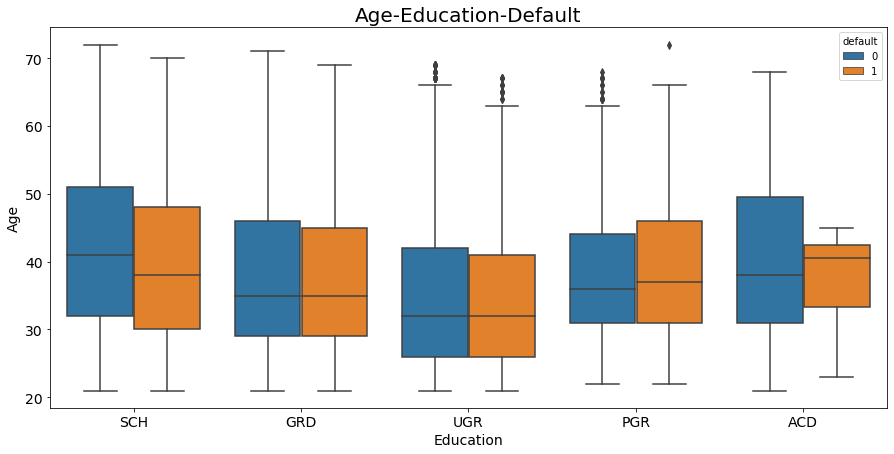

In [24]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='education', y='age', hue='default', data=df)

plt.title('Age-Education-Default', fontsize=20)
plt.ylabel('Age', fontsize=14)
plt.xlabel('Education', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Интересно то, что если мы берем уровень образования PGR и ACD, то среднее значение возраста у "плохих" заемщиков выше, чем у "хороших", но сам разброс значений и у тех и у тех также высокий. Возможно, если мы берем какой то предел возраст, например, от 30 до 50 лет, то внутри этой группы данный показатель не сильно будет влиять на полную выплату кредита.

Можно найти средние значения возраста для каждой подгруппы

In [25]:
df.groupby('education')['age'].median()

education
ACD    38.0
GRD    35.0
PGR    36.0
SCH    40.0
UGR    32.0
Name: age, dtype: float64

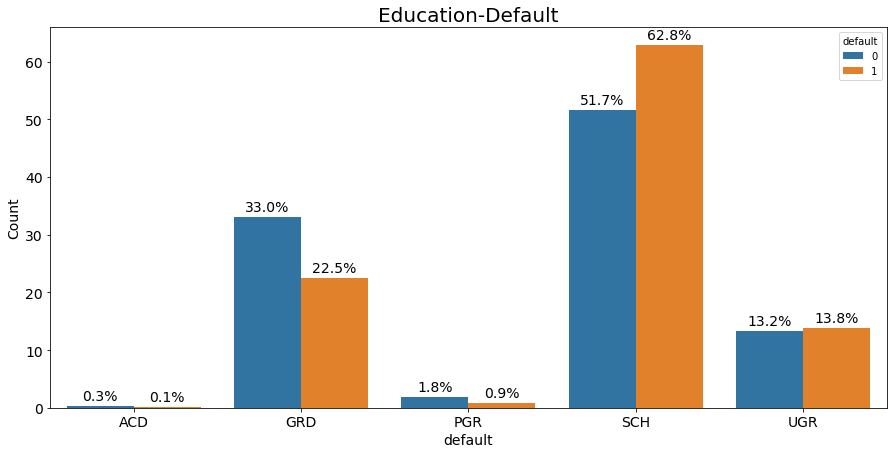

In [26]:
plt.figure(figsize=(15, 7))

educ_def = (df.groupby(['default'])['education']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('education'))

ax = sns.barplot(x="education", y="percentage", hue="default", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Education-Default', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('default', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Аналогично видим, что процент недобросовестных замщиков выше с уровнем образования SCH, для UGR разница не значительная. Скорее в данном случае влияет не как сам возраст, а уровень образования. Также можно отменить, что в какой то стемени GRD - более стабильны в плане выплат.

## Corr

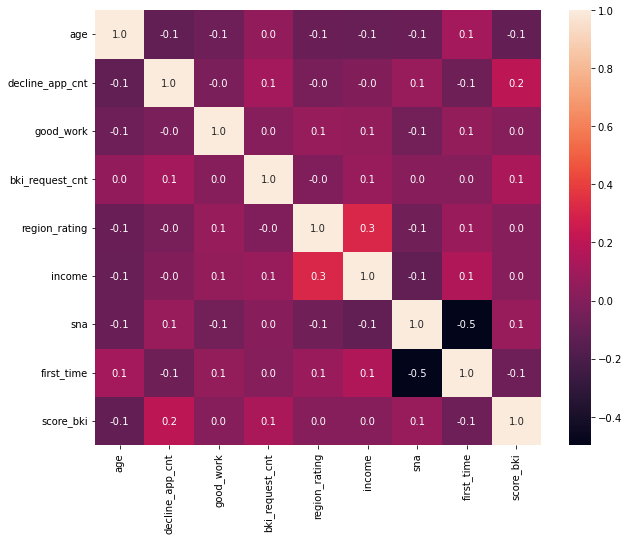

In [27]:
num_cols = ['age', 'decline_app_cnt', 'good_work', 'bki_request_cnt',
       'region_rating', 'income', 'sna', 'first_time', 'score_bki']

plt.figure(figsize=(10, 8))

sns.heatmap(df[num_cols].corr(method='spearman'), annot=True, fmt=".1f");

## Income

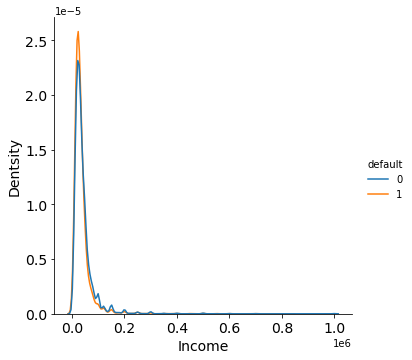

In [28]:
sns.displot(df, x='income', hue='default', kind="kde", common_norm=False)

plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

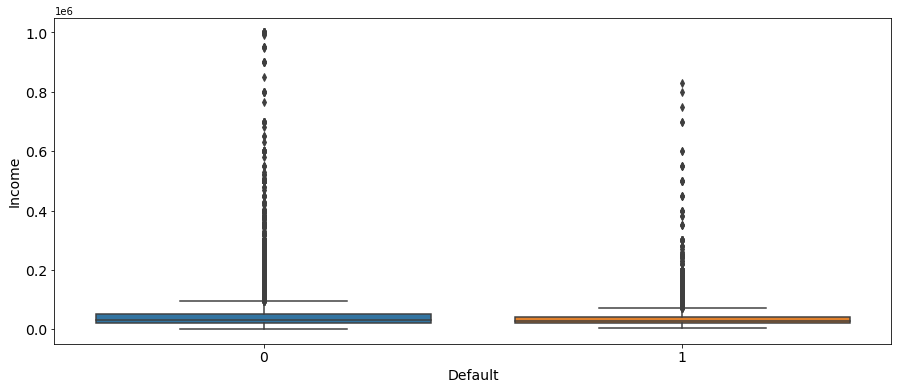

In [29]:
plt.figure(figsize=(15, 6))

sns.boxplot(x='default', y='income', data=df)

plt.ylabel('Income', fontsize=14)
plt.xlabel('Default', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [30]:
df.groupby('default')['income'].mean()

default
0    41799.713288
1    36288.113316
Name: income, dtype: float64

In [31]:
df.groupby('default')['income'].median()

default
0    30000.0
1    28000.0
Name: income, dtype: float64

In [33]:
df_income = df.copy()
df_income.income = np.log(df.income+1)

Зарплата, также будет очень сильно влиять на нашу модель, потому что разбор примерно в 8000

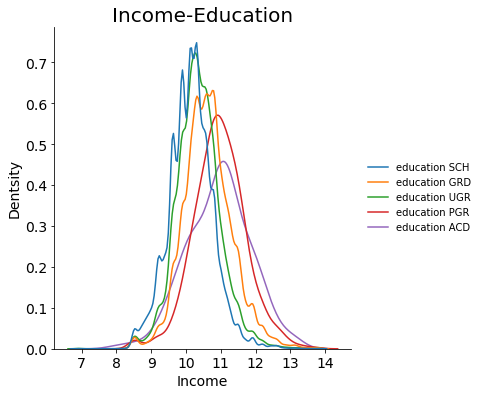

In [34]:
sns.displot(
    {
        "education SCH": df_income[df_income.education == 'SCH'].income,
        "education GRD": df_income[df_income.education == 'GRD'].income,
        "education UGR": df_income[df_income.education == 'UGR'].income,
        "education PGR": df_income[df_income.education == 'PGR'].income,
        "education ACD": df_income[df_income.education == 'ACD'].income,
    },
    kind="kde",
    common_norm=False
)

plt.title('Income-Education', fontsize=20)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Более хорошие заемщики - PGR и ACD, ,более важная переменная - SCH

.....

# Feature engineering

In [35]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default'],
      dtype='object')

In [36]:
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'income', 'first_time','region_rating']

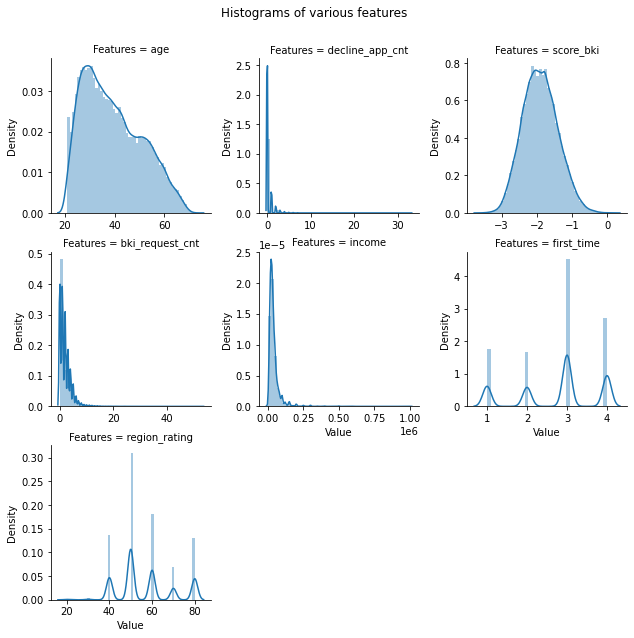

In [37]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

Логорифмируем те распределения, которые слишком прилипают к нулю

In [39]:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']:
    df[i] = np.log(df[i]+1)

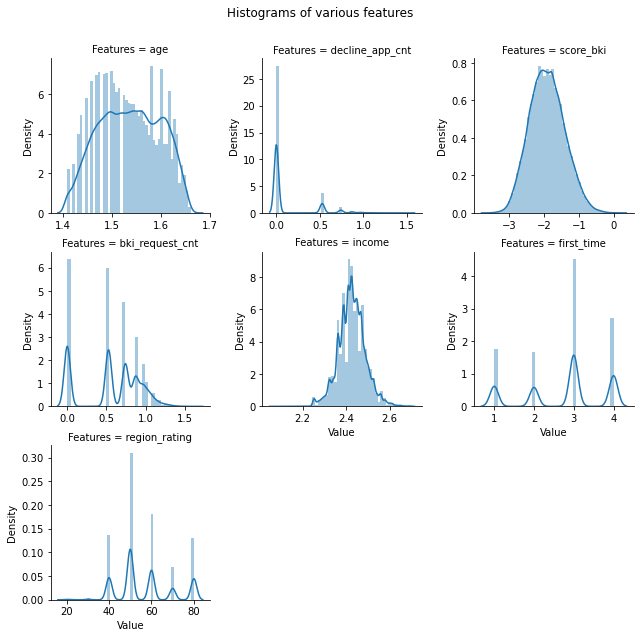

In [40]:
numeric_features = df[num_cols]

numeric_features = numeric_features.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=numeric_features, col="Features",
                  col_wrap=3, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.9)
plt.suptitle("Histograms of various features");

In [41]:
# Новый признак - месяц
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')
df['month'] = df['app_date'].dt.month.astype(object)

df.drop(['app_date'],  axis=1, inplace=True)

In [42]:
# Средний доход с учетом рейтинга региона

mean_inc_reg = df.groupby('region_rating')['income'].median().to_dict()
df['mean_income_region'] = df['region_rating'].map(mean_inc_reg)

In [43]:
# Средний доход с учетом возраста

mean_inc_age = df.groupby('age')['income'].median().to_dict()
df['mean_income_age'] = df['age'].map(mean_inc_age)

In [44]:
# Средний score bki с учетом возраста

mean_bki_age = df.groupby('age')['score_bki'].median().to_dict()
df['mean_bki_age'] = df['age'].map(mean_bki_age)

In [45]:
df[:5]

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,month,mean_income_region,mean_income_age,mean_bki_age
0,25905,SCH,M,1.637663,Y,Y,0.000000,0,-2.008753,0.526589,...,2,2.379378,4,1,N,0,2,2.409345,2.389087,-1.981476
1,63161,SCH,F,1.628131,N,N,0.000000,0,-1.532276,0.869742,...,3,2.384372,4,1,N,0,3,2.409345,2.397790,-1.994864
2,25887,SCH,M,1.448822,Y,N,0.741276,0,-1.408142,0.526589,...,2,2.425598,1,4,Y,0,2,2.464527,2.425598,-1.814637
3,16222,SCH,F,1.607232,N,N,0.000000,0,-2.057471,0.741276,...,3,2.323411,1,3,N,0,1,2.409345,2.417056,-1.993905
4,101655,GRD,M,1.587564,N,N,0.000000,1,-1.244723,0.526589,...,3,2.425598,1,4,Y,0,4,2.425598,2.425598,-1.988764


In [46]:
cat_cols = ['education', 'sex', 'car', 'car_type', 'good_work', 'home_address', 'work_address',
       'foreign_passport', 'sna', 'month']

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   client_id           73799 non-null  int64  
 1   education           73799 non-null  object 
 2   sex                 73799 non-null  object 
 3   age                 73799 non-null  float64
 4   car                 73799 non-null  object 
 5   car_type            73799 non-null  object 
 6   decline_app_cnt     73799 non-null  float64
 7   good_work           73799 non-null  int64  
 8   score_bki           73799 non-null  float64
 9   bki_request_cnt     73799 non-null  float64
 10  region_rating       73799 non-null  int64  
 11  home_address        73799 non-null  object 
 12  work_address        73799 non-null  object 
 13  income              73799 non-null  float64
 14  sna                 73799 non-null  int64  
 15  first_time          73799 non-null  int64  
 16  fore

In [48]:
num_cols = list(df.dtypes[df.dtypes == float].index) + list(df.dtypes[df.dtypes == int].index)[1:-1]

In [49]:
num_cols

['age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'mean_income_region',
 'mean_income_age',
 'mean_bki_age']

# Моделирование

In [51]:
df_label = pd.get_dummies(df, columns=cat_cols,
                          drop_first=True).drop('client_id', axis=1)

In [52]:
df_label[:5]

,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income,first_time,default,mean_income_region,mean_income_age,...,home_address_3,work_address_2,work_address_3,foreign_passport_Y,sna_2,sna_3,sna_4,month_2,month_3,month_4
0,1.637663,0.000000,-2.008753,0.526589,50,2.379378,1,0,2.409345,2.389087,...,0,1,0,0,0,0,1,1,0,0
1,1.628131,0.000000,-1.532276,0.869742,50,2.384372,1,0,2.409345,2.397790,...,0,0,1,0,0,0,1,0,1,0
2,1.448822,0.741276,-1.408142,0.526589,80,2.425598,4,0,2.464527,2.425598,...,0,1,0,1,0,0,0,1,0,0
3,1.607232,0.000000,-2.057471,0.741276,50,2.323411,3,0,2.409345,2.417056,...,0,0,1,0,0,0,0,0,0,0
4,1.587564,0.000000,-1.244723,0.526589,60,2.425598,4,0,2.425598,2.425598,...,0,0,1,1,0,0,0,0,0,1


In [54]:
X = df_label.drop('default', axis=1)
y = df_label['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, shuffle=True, random_state=RAND)

# Необходимо поставить stratify, чтобы была необходимая балансировка

## Baseline

In [55]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_score = lr.predict_proba(X_test)[:,1]

In [56]:
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))
print('logloss:', log_loss(y_test, y_pred))

roc-auc: 0.7281905649057715
precision: 0.2298471681150734
recall: 0.6547161758429364
f1: 0.3402462016191638
logloss: 11.136872124884274


Если банку выгоднее пресказать лучше больше "плохих" клиентов, чтобы избежать большие потери, то лучше ориентироваться еще на метрику recall, если будем сравнивать в baseline и другими алгоритмами, иначе precision.

<img src='http://3.bp.blogspot.com/-cS83mPIWFqU/Wuq1vw0TrpI/AAAAAAAACY8/qEVMoTUmvkIwNbtbrELeGhJoC4yYsrVrQCK4BGAYYCw/s1600/prec.png' width="300">
<img src='http://1.bp.blogspot.com/-_-bHkzJAneg/Wuq1oUu_vTI/AAAAAAAACY0/E2UIsd359x0GV_9IgGv0Iax6Z3kGYM9dQCK4BGAYYCw/s1600/rec.png' width="250">

Добавим метрики в таблицу

In [57]:
metrics = pd.DataFrame(
    index=['roc-auc', 'precision', 'recall', 'f1', 'logloss'])

metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]

In [58]:
metrics

,Baseline_LR
roc-auc,0.728191
precision,0.229847
recall,0.654716
f1,0.340246
logloss,11.136872


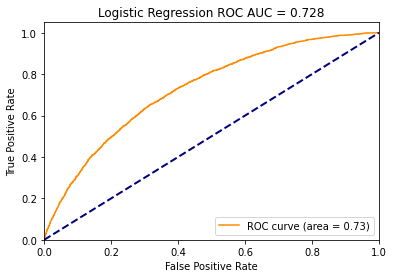

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

# Подбор параметров

In [60]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid,
                       scoring='roc_auc', cv=cv, verbose=2)

In [61]:
%%time
# производим обучение по сетке
#grid_cv.fit(X_train, y_train)

Wall time: 0 ns


In [62]:
#print(grid_cv.best_score_)
#print(grid_cv.best_params_)

In [63]:
best_params = {'C': 500.5, 
               'l1_ratio': 0.25,
               'max_iter': 400, 
               'penalty': 'l2', 
               'solver': 'lbfgs'}

In [64]:
lr_gr = LogisticRegression(**best_params, class_weight='balanced')
lr_gr.fit(X_train, y_train)

y_pred_gr = lr_gr.predict(X_test)
y_score_gr = lr_gr.predict_proba(X_test)[:,1]

In [65]:
print('roc-auc:', roc_auc_score(y_test, y_score_gr))
print('precision:', precision_score(y_test, y_pred_gr))
print('recall:', recall_score(y_test, y_pred_gr))
print('f1:', f1_score(y_test, y_pred_gr))
print('logloss:', log_loss(y_test, y_pred_gr))

roc-auc: 0.7288559826158298
precision: 0.23073463268365818
recall: 0.6568501920614597
f1: 0.34150671252635084
logloss: 11.110663449225433


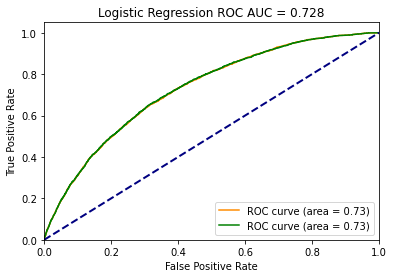

In [66]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_score_gr)

roc_auc_2 = auc(fpr_2, tpr_2)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green', label='ROC curve (area = %0.2f)' % roc_auc_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

In [67]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_gr),
                      precision_score(y_test, y_pred_gr),
                      recall_score(y_test, y_pred_gr),
                      f1_score(y_test, y_pred_gr),
                      log_loss(y_test, y_pred_gr)]

In [68]:
metrics[:-1].style.highlight_max(axis=1, color='lightblue')

,Baseline_LR,Grid_LR
roc-auc,0.728191,0.728856
precision,0.229847,0.230735
recall,0.654716,0.656850
f1,0.340246,0.341507


# Анализ важных признаков (shap)

In [71]:
 !pip install shap

In [72]:
import shap

In [73]:
explainer = shap.LinearExplainer(lr_gr, X_train, feature_dependence="independent")
shap_values = explainer(X_test)

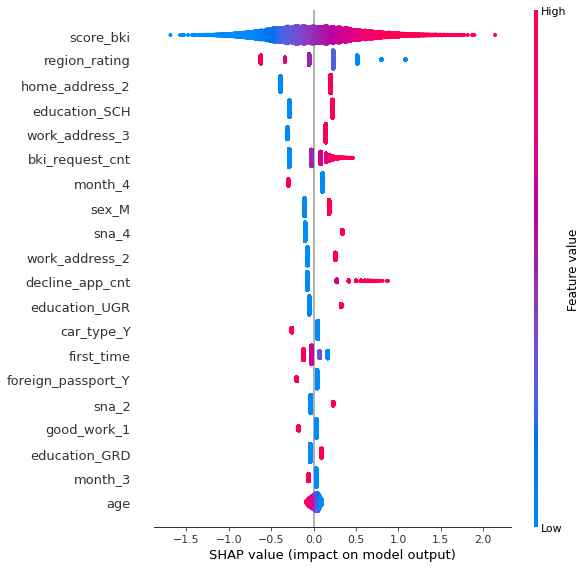

In [74]:
# summary plot
shap.summary_plot(shap_values, X_test)

Признаки расположены по степени их важности по оси OY, по оси OX находится значение Шепли. Каждая точка является отдельно взятым наблюдением.

Цветом обозначены значения соответствующего признака: красный - высокие, синий - низкие. 

**Расмотрим пример:**
- чем больше значение признака score_bki, тем больше вероятность дефолта;
- чем больше значение признака age, тем меньше вероятность дефолта.

Сравним с весами из логистической регресии, а также проверим на нескольких признаках

In [75]:
lr_gr.coef_

array([[-0.70805119,  0.6605728 ,  1.00827636,  0.49904751, -0.02838609,
        -0.21895344, -0.09549339,  0.33773494,  0.90395381, -0.25963354,
         0.13143959, -0.04064215,  0.50584333,  0.37814894,  0.28865826,
         0.01587108, -0.30479899, -0.20986741,  0.5939341 ,  0.10812055,
         0.32850749,  0.45400527, -0.23909081,  0.26418014,  0.16567582,
         0.44028517, -0.04731948, -0.09031057, -0.40575287]])

In [76]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X.columns
feature_imp['imp'] = lr_gr.coef_[0]
feature_imp = feature_imp.sort_values(by='imp', ascending=False)

In [77]:
feature_imp

,feature,imp
2,score_bki,1.008276
8,mean_income_age,0.903954
1,decline_app_cnt,0.660573
18,home_address_2,0.593934
12,education_SCH,0.505843
3,bki_request_cnt,0.499048
21,work_address_3,0.454005
25,sna_4,0.440285
13,education_UGR,0.378149
7,mean_income_region,0.337735


Медианное значение score_bki Ниже у хороших заемщиков нижу чем у плохих

In [79]:
df_label.groupby('default')[['score_bki']].median()

,score_bki
default,
0,-1.956982
1,-1.683857


In [80]:
vals = np.abs(shap_values.values).mean(0)
feature_names = X_train

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name', 'feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

In [81]:
cols_show = list(set(feature_importance.col_name[:15]) & set(num_cols))

In [82]:
cols_show

['score_bki', 'bki_request_cnt', 'decline_app_cnt']

In [83]:
df_label[cols_show + ['default']].groupby('default')[cols_show].mean().T

default,0,1
score_bki,-1.938048,-1.675637
bki_request_cnt,0.551810,0.637167
decline_app_cnt,0.095197,0.185677
